### Урок 4. Деревья решений

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [3]:
x = X[2,:]
print(x)
print(y)
print(x >= 1000)
print(y[x >= 1000])
right_1 = (y[x >= 1000] == 0)
right_2 = (y[x >= 1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False  True False  True  True False  True]
[1. 1. 0. 1.]
Нулей: 1 единиц: 3


In [4]:
def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Индекс Джини не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, так как получается только одна ветвь
    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()

    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    # Индекс Джини для левого листа
    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    # Индекс Джини для правого листа
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [5]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [6]:
print(y[x >= 1000])
i, c = gini(y[x >= 1000])
print(i, c)

print(y[x < 1000])
i, c = gini(y[x < 1000])
print(i, c)

[1. 1. 0. 1.]
0.375 {1.0: 3, 0.0: 1}
[0. 0. 1. 0. 0. 1.]
0.4444444444444445 {0.0: 4, 1.0: 2}


In [7]:
# Расчёт прироста качества при разбиении вершины дерева

def quality_0(left_labels, right_labels):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right

In [8]:
for t in x:
    print('Порог: {}, gini = {} ({})'.format(t, calc_gini(x, y, t), quality_0(y[x < t], y[x >= t])))

Порог: 500.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 700.0, gini = 0.47619047619047616 (0.47619047619047616)
Порог: 750.0, gini = 0.4166666666666667 (0.4166666666666667)
Порог: 600.0, gini = 0.5 (0.5)
Порог: 1450.0, gini = 0.47619047619047616 (0.4761904761904763)
Порог: 800.0, gini = 0.48 (0.48)
Порог: 1500.0, gini = 0.5 (0.5)
Порог: 2000.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 450.0, gini = inf (0.5)
Порог: 1000.0, gini = 0.4166666666666667 (0.4166666666666667)


## Практическое задание

1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.
2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [29]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

100

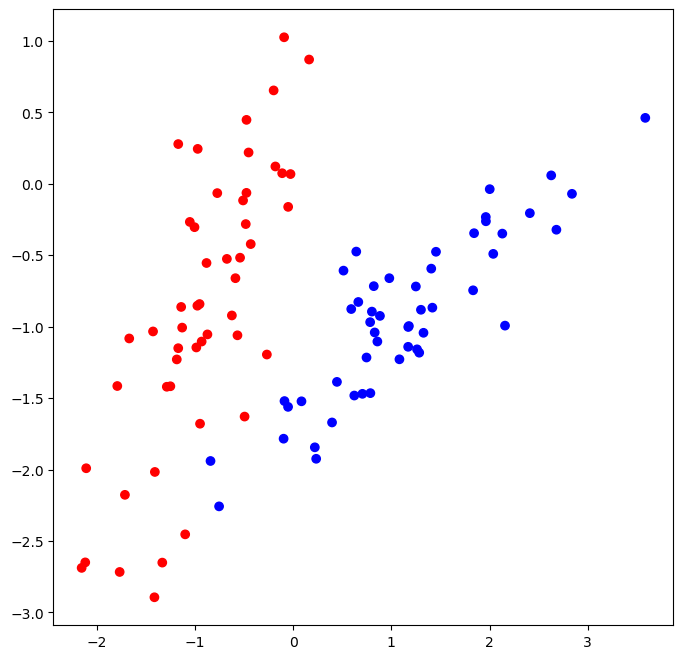

In [10]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [11]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [12]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [13]:
# Расчёт качества
def quality(left_labels, right_labels, current_gini):
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * (gini(left_labels)[0]) - (1 - p) * (gini(right_labels)[0])

In [14]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    current_gini = gini(labels)[0]
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    for index in range(n_features):
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index

In [16]:
# Построение дерева посредством рекурсивной функции
def build_tree(data, labels):
    # Если данные одного класса - создаем лист
    if all(labels) or not any(labels):
        return Leaf(data, labels)
    quality, t, index = find_best_split(data, labels)
    #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [19]:
# Разобьём выборку на обучающую и тестовую
from sklearn import model_selection
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [20]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [21]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))
    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")
    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [22]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [23]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [24]:
# Введём функцию подсчёта точности, как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [25]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [26]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

In [27]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # Для предсказания будем использовать медиану
        return np.median(labels)        

In [ ]:
# Расчёт критерия Энтропии

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * numpy.log(p)
        
    return impurity, classes